In [35]:
import torch
import phate
import scprep
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle

In [36]:
tree_data, tree_clusters = phate.tree.gen_dla(n_dim=10, n_branch=5, branch_length=30)

In [37]:
phate_operator = phate.PHATE(random_state=42)
tree_phate = phate_operator.fit_transform(tree_data)

Calculating PHATE...
  Running PHATE on 150 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 25
  Calculated optimal t in 0.01 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.01 seconds.
Calculated PHATE in 0.04 seconds.


(150, 10)
(150, 2)
(150,)


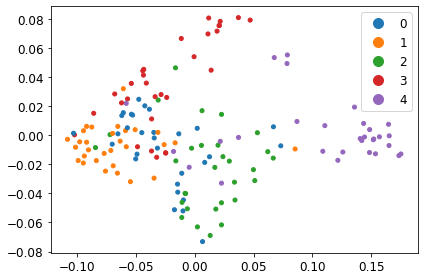

In [38]:
cax = scprep.plot.scatter2d(tree_phate, c=tree_clusters)
print(tree_data.shape)
print(tree_phate.shape)
print(tree_clusters.shape)

In [39]:
X = torch.tensor(tree_data, requires_grad=True)
n = 150
random_indices = np.random.randint(tree_data.shape[0], size=n)

In [40]:
%%time


def torch_phate(X, kernel="gaussian", bandwidth=1000, t=10):
    dists = torch.norm(X[:, None] - X, dim=2, p="fro")

    def gaussian_kernel(x):
        return torch.exp(-(dists**2) / bandwidth)

    kernel = gaussian_kernel(dists)
    p = kernel / kernel.sum(axis=0)[:, None]
    pt = torch.matrix_power(p, t)
    log_p = torch.log(pt)
    return pt


P = torch_phate(X[random_indices])

# assert torch.abs(torch.exp(P[0]).sum() - 1) < 1e-3

J = torch.autograd.functional.jacobian(torch_phate, X[random_indices])
# shape: N_output [N x N], input [N x D]

Jt = J.transpose(1, 2)

fischer_information = torch.sum(J * Jt * P[:, :, None, None], dim=1)
fischer_information_flat = fischer_information.reshape(n, -1)


phate_operator_inf = phate.PHATE(knn=5, decay=20, t=150, random_state=42)
tree_phate_inf = phate_operator_inf.fit_transform(
    fischer_information_flat.detach().numpy()
)

Calculating PHATE...
  Running PHATE on 150 observations and 1500 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.02 seconds.
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.04 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
    Using SMACOF because SGD returned NaN
  Calculated metric MDS in 0.02 seconds.
Calculated PHATE in 0.06 seconds.
CPU times: user 4min 18s, sys: 805 ms, total: 4min 19s
Wall time: 32.7 s


In [ ]:
torch.autograd.functional.jacobian(torch_phate, X).shape

In [ ]:
fischer_information.shape

With the Autoencoder

In [21]:
import torch.nn as nn


class Autoencoder(nn.Module):
    def __init__(
        self,
        encoder_layer=[10, 10, 10],
        decoder_layer=[10, 10, 10],
        activation="ReLU",
        use_cuda=False,
    ) -> None:
        super().__init__()
        device = "cuda" if use_cuda else "cpu"
        encoder = []
        for i0, i1 in zip(encoder_layer, encoder_layer[1:]):
            encoder.append(nn.Linear(i0, i1))
            if i1 == 10:
                encoder.append(getattr(nn, "ReLU")())
            else:
                encoder.append(getattr(nn, "ReLU")())
        print(encoder)
        self.encoder = nn.Sequential(*encoder).to(device)
        # decoder=[]
        # for i0,i1 in zip(decoder_layer,decoder_layer[1:]):
        #   decoder.append(nn.Linear(i0, i1))
        #   decoder.append(getattr(nn, activation)())
        # self.decoder = nn.Sequential(*decoder).to(device)

    # def encode(self,x):
    #   return self.encoder(x)

    # def decoder(self,x):
    #   return self.decoder(x)

    def forward(self, x):
        x = self.encoder(x)
        return x  # self.decoder(x)

In [45]:
use_cuda = torch.cuda.is_available()
phate_ae = Autoencoder(
    encoder_layer=[10, 10, 2], decoder_layer=[10, 10, 10], use_cuda=use_cuda
)
optimizer = torch.optim.AdamW(phate_ae.parameters(), lr=0.0001)

n_epochs = 5000
n = 100

fullind = np.arange(tree_data.shape[0])
random_indices = np.random.choice(
    fullind, size=n, replace=False
)  # Get 100 random indices


for epoch in range(n_epochs):
    np.random.shuffle(random_indices)
    optimizer.zero_grad()

    X_sample = X[random_indices].float()  # Get 100 samples
    P = torch_phate(X_sample).cuda()  # Get log proability

    noise = (
        (0.05 * torch.randn(X_sample.size())).cuda()
        if use_cuda
        else 0.05 * torch.randn(X_sample.size())
    )  # define noise from Gaussina distribution
    encode_sample = phate_ae.forward(
        X_sample.cuda() + noise.cuda()
    )  # encode phate into 2 dimensions

    loss = nn.MSELoss()(
        torch.cdist(encode_sample, encode_sample) ** 2, torch.cdist(P, P) ** 2
    )  # Loss between encoded space and diffusion distance

    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print("Loss distance :", loss)

[Linear(in_features=10, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=2, bias=True), ReLU()]
Loss distance : tensor(14.8837, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss distance : tensor(1.2423, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss distance : tensor(0.2796, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss distance : tensor(0.0995, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss distance : tensor(0.0439, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss distance : tensor(0.0229, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss distance : tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss distance : tensor(0.0061, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss distance : tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss distance : tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)


In [15]:
print(phate_ae.encoder[0])

Linear(in_features=10, out_features=10, bias=True)


[array([[-0.06545092,  0.01784505,  0.077741  ,  0.09808814,  0.04512549,
        -0.03124253,  0.01435452, -0.0102352 ,  0.10941847, -0.12080658],
       [ 0.00657894,  0.10389663, -0.03017157, -0.06703389, -0.10243928,
         0.03304972, -0.03010248, -0.09961281, -0.01694007,  0.07030053]],
      dtype=float32), array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32), array([[-0.06371399,  0.1942225 ,  0.0232567 , -0.01577149, -0.15679063,
        -0.00026444,  0.05681403, -0.04294632,  0.01409182, -0.13910386],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],
      dtype=float32), array([[-0.13903782,  0.14285395,  0.11235856,  0.0331398 ,  0.0490386 ,
        -0.07284128, -0.00730211, -0.09104583,  0.08492512, -0.15581381],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.      

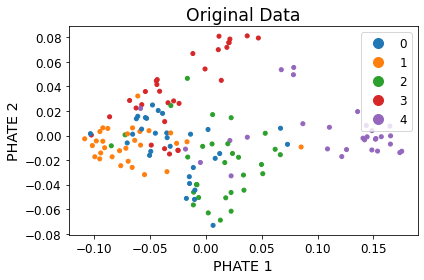

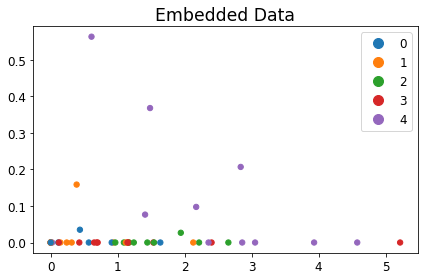

In [44]:
# Get test indices
testind = []
fullind = list(np.arange(tree_data.shape[0]))
for i in fullind:
    if i not in random_indices:
        testind.append(i)

testind = np.array(testind)

# Get samples from autoencoder
nxsample = phate_ae.encoder(X[testind].float().cuda())
xsampout = nxsample.detach().cpu().numpy()

# Visualize ground truth
cax = scprep.plot.scatter2d(
    tree_phate,
    c=tree_clusters,
    title="Original Data",
    xlabel="PHATE 1",
    ylabel="PHATE 2",
)


# Visualize Embedding
cax = scprep.plot.scatter2d(xsampout, c=tree_clusters[testind], title="Embedded Data")


# Compute Jacobian
Jacob = []
for i in testind:
    X_sample = X[i].float().cuda()
    J = torch.autograd.functional.jacobian(phate_ae.encoder, X_sample).squeeze()
    Jacob.append(J.cpu().detach().numpy())

# Compute FIM
FIM = []
for i in range(testind.shape[0]):
    FIM.append( (Jacob[i] @ Jacob[i].T) * np.exp(xsampout[i, :]))
    
    
print(Jacob)

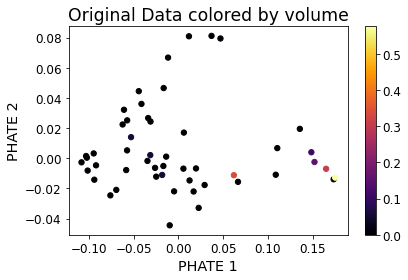

In [43]:
# Analysis

#Compute Volume
V = np.sqrt(np.linalg.det(FIM))

#Visualize Original PHATE data with volume measurement
# Visualize ground truth
cax = scprep.plot.scatter2d(
    tree_phate[testind],
    c=V,
    title="Original Data colored by volume",
    xlabel="PHATE 1",
    ylabel="PHATE 2",
)



IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

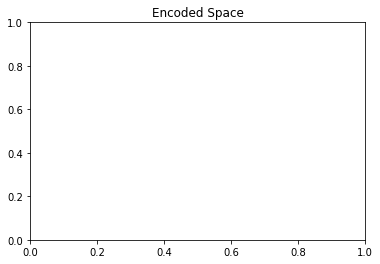

In [18]:
# Plot output of embedding space
nxsample = phate_ae.encoder(X_sample)
plt.figure()
plt.title("Encoded Space")
plt.scatter(
    nxsample.detach().cpu().numpy()[:, 0], nxsample.detach().cpu().numpy()[:, 1]
)


# Encoded space
cax = scprep.plot.scatter2d(tree_phate, c=tree_clusters)

In [ ]:
# NOTE Not using the cells under this.
# Extract Jacobians and compute FIM tensor

# get new data points
print(X_sample.shape)
nxsample = phate_ae.encoder(X_sample)
print(nxsample.shape)

# Check shape
print(J.shape)
Jr = J.transpose(1, 2)
print(Jr.shape)


jtensor = np.empty((n, 2, 10))  # Gets n jacobian's for n data points
for i in range(n):
    for j in range(n):

        if Jr[i, j, :, :].squeeze().cpu().detach().numpy().max() > 0.0:
            jtensor[i, :, :] = Jr[i, j, :, :].squeeze().cpu().detach().numpy()

print("Jacobian Tensor Shape (for each data point)", jtensor.shape)
# The correct way to get FIM's

FIMtens = np.empty((n, 2, 2))  # FIM for each point
for i in range(n):
    FIMtens[i, :, :] = (
        jtensor[i, :, :].squeeze() @ jtensor[i, :, :].squeeze().T
    ) @ nxsample[i, :].cpu().detach().numpy().T

FIMtenstot = FIMtens.mean(0).squeeze()  # FIM expectation over all data points
print(FIMtenstot)
print(jtensor)

In [ ]:
# from math import prod
n = 100
random_indices = np.random.randint(tree_data.shape[0], size=n)
X_sample = X[random_indices].float()
fim = []

J = torch.autograd.functional.jacobian(
    phate_ae.encoder[1], phate_ae.encoder[0](X_sample)
)
J = J.view(n, n, -1)


# for i in range(n):
#   jac = J[i,:,i,:]
#   jac_t = jac.T
#   fim.append(torch.sum(jac*jac_t, dim=1))
# J = J.transpose(1, 2)
# Jt = J.transpose(2, 3)
# Jt = Jt.transpose(2, 3)
fischer_information = torch.sum(J * Jt, dim=1)
fischer_information_flat = fischer_information.reshape(n, -1)

# fischer_information_flat = torch.vstack(fim).reshape(n, -1)
# J = jacobianBatch(phate_ae.encoder,X_sample)
# Jt = J.transpose(1, 2)
# fischer_information = torch.mul(J,Jt)
# fischer_information_flat = fischer_information.reshape(n, -1)

phate_operator_inf = phate.PHATE(knn=5, decay=20, t=150, random_state=42)
tree_phate_inf = phate_operator_inf.fit_transform(
    fischer_information_flat.detach().numpy()
)

In [ ]:
J.shape, Jt.shape, fischer_information.shape

In [ ]:
cax = scprep.plot.scatter2d(tree_phate_inf, c=tree_clusters[random_indices])

In [ ]:
def jacobianBatch(f, wrt):
    """
    Compute the jacobian (derivaties of outputs w.r.t inputs)
    Input:
            f: pytorch model
            wrt: batch of training data
    Output:
            jacobian: J of the batch of training data
    """
    jacobian = []
    f.eval()
    for i in range(wrt.shape[0]):
        jac = torch.autograd.functional.jacobian(f, wrt[i])
        jacobian.append(jac)
        #
    return torch.stack(jacobian, 0)

other try

In [28]:
use_cuda = torch.cuda.is_available()
phate_ae = Autoencoder(
    encoder_layer=[10, 10, 100], decoder_layer=[10, 10, 10], use_cuda=use_cuda
)
optimizer = torch.optim.AdamW(phate_ae.parameters())

n_epochs = 5000
n = 100

for epoch in range(n_epochs):
    optimizer.zero_grad()
    random_indices = np.random.randint(tree_data.shape[0], size=n)
    X_sample = (
        X[random_indices].float().cuda()
        if use_cuda
        else X[random_indices].float().cuda()
    )
    P = torch_phate(X_sample)
    noise = (
        (0.05 * torch.randn(X_sample.size())).cuda()
        if use_cuda
        else 0.05 * torch.randn(X_sample.size())
    )
    encode_sample = phate_ae.forward(X_sample + noise)
    loss = nn.MSELoss()(
        torch.cdist(encode_sample, encode_sample) ** 2, torch.cdist(P, P) ** 2
    )

    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print("Loss distance:", loss)

[Linear(in_features=10, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=100, bias=True), ReLU()]
Loss distance: tensor(16082.9609, device='cuda:0', grad_fn=<MseLossBackward>)
Loss distance: tensor(32.4330, device='cuda:0', grad_fn=<MseLossBackward>)
Loss distance: tensor(11.9265, device='cuda:0', grad_fn=<MseLossBackward>)
Loss distance: tensor(4.6755, device='cuda:0', grad_fn=<MseLossBackward>)
Loss distance: tensor(1.7165, device='cuda:0', grad_fn=<MseLossBackward>)
Loss distance: tensor(1.1716, device='cuda:0', grad_fn=<MseLossBackward>)
Loss distance: tensor(0.9577, device='cuda:0', grad_fn=<MseLossBackward>)
Loss distance: tensor(0.4384, device='cuda:0', grad_fn=<MseLossBackward>)
Loss distance: tensor(0.2616, device='cuda:0', grad_fn=<MseLossBackward>)
Loss distance: tensor(0.1708, device='cuda:0', grad_fn=<MseLossBackward>)


In [27]:
n = 100
random_indices = np.random.randint(tree_data.shape[0], size=n)
X_sample = X[random_indices].float()
fim = []
J = torch.autograd.functional.jacobian(phate_ae.encoder, X_sample)

Jt = J.transpose(1, 2)
fischer_information = torch.sum(J * Jt, dim=1)
fischer_information_flat = fischer_information.reshape(n, -1)

phate_operator_inf = phate.PHATE(knn=5, decay=20, t=150, random_state=42)
tree_phate_inf = phate_operator_inf.fit_transform(
    fischer_information_flat.detach().numpy()
)

Calculating PHATE...
  Running PHATE on 100 observations and 1000 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.03 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
    Using SMACOF because SGD returned NaN
Calculated PHATE in 0.04 seconds.


/home/mila/g/guillaume.huguet/.local/lib/python3.6/site-packages/graphtools/graphs.py:121: UserWarning: Building a kNNGraph on data of shape (100, 1000) is expensive. Consider setting n_pca.
  UserWarning,
/home/mila/g/guillaume.huguet/.local/lib/python3.6/site-packages/graphtools/graphs.py:293: RuntimeWarning: Detected zero distance between 892 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  RuntimeWarning,
/home/mila/g/guillaume.huguet/.local/lib/python3.6/site-packages/graphtools/graphs.py:451: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


In [ ]:
cax = scprep.plot.scatter2d(tree_phate_inf, c=tree_clusters[random_indices])